<a href="https://colab.research.google.com/github/Laura-VFA/MachineLearning-21-22/blob/main/ML_Deliverable2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ML2021 - Assesment Work (Regression)

The challenge is to predict Workers Compensation claims using realistic data.

**Model Evaluation**: MSE, $R^2$, ...

## Data Loading 




1. Download the train data

In [1]:
!wget https://github.com/curso-iabd-uclm/machinelearning/raw/main/insurance/train.csv

--2021-12-07 16:31:18--  https://github.com/curso-iabd-uclm/machinelearning/raw/main/insurance/train.csv
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/curso-iabd-uclm/machinelearning/main/insurance/train.csv [following]
--2021-12-07 16:31:19--  https://raw.githubusercontent.com/curso-iabd-uclm/machinelearning/main/insurance/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4942050 (4.7M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]   4.71M  --.-KB/s    in 0.08s   

2021-12-07 16:31:20 (60.4 MB/s) - ‘train.csv’ saved [4942050/4942050]



In [2]:
import pandas as pd
df = pd.read_csv("train.csv")
df.head()

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost
0,WC8205482,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203388
1,WC6922469,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.285819
2,WC5442654,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,30,M,U,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.949087
3,WC9796897,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,41,M,S,0,0,555.46,F,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,15000,17786.487170
4,WC2603726,1990-08-29T08:00:00Z,1990-09-27T00:00:00Z,36,M,M,0,0,377.10,F,38.0,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,2800,4014.002925


The training set containing 30,000 insurance policies that you can use to train your model.

**Data fields**

-  ClaimNumber: Unique policy identifier
- DateTimeOfAccident: Date and time of accident
- DateReported: Date that accident was reported
- Age: Age of worker
- Gender: Gender of worker
- MaritalStatus: Martial status of worker. (M)arried, (S)ingle, (U)unknown.
- DependentChildren: The number of dependent children
- DependentsOther: The number of dependants excluding children
- WeeklyWages: Total weekly wage
- PartTimeFullTime: Binary (P) or (F)
- HoursWorkedPerWeek: Total hours worked per week
- DaysWorkedPerWeek: Number of days worked per week
- ClaimDescription: Free text description of the claim
- InitialIncurredClaimCost: Initial estimate by the insurer of the claim cost
- **UltimateIncurredClaimCost**: Total claims payments by the insurance company. This is the field you are asked to predict in the test set.

In [3]:
df.columns

Index(['ClaimNumber', 'DateTimeOfAccident', 'DateReported', 'Age', 'Gender',
       'MaritalStatus', 'DependentChildren', 'DependentsOther', 'WeeklyWages',
       'PartTimeFullTime', 'HoursWorkedPerWeek', 'DaysWorkedPerWeek',
       'ClaimDescription', 'InitialIncurredCalimsCost',
       'UltimateIncurredClaimCost'],
      dtype='object')

In [4]:
df.head()

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost
0,WC8205482,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203388
1,WC6922469,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.285819
2,WC5442654,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,30,M,U,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.949087
3,WC9796897,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,41,M,S,0,0,555.46,F,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,15000,17786.487170
4,WC2603726,1990-08-29T08:00:00Z,1990-09-27T00:00:00Z,36,M,M,0,0,377.10,F,38.0,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,2800,4014.002925


## Preprocessing

We transform the data in order to allow us the posterior use of the algorithms to build prediction models, for example, missing values, from categories to numbers, ...



### Missing Values

It is necessary to address the missing values to improve the quality of the data that will be used to generate the models. 

In [5]:
df.shape

(36176, 15)

In [6]:
pd.isnull(df).any()

ClaimNumber                  False
DateTimeOfAccident           False
DateReported                 False
Age                          False
Gender                       False
MaritalStatus                 True
DependentChildren            False
DependentsOther              False
WeeklyWages                   True
PartTimeFullTime             False
HoursWorkedPerWeek            True
DaysWorkedPerWeek            False
ClaimDescription             False
InitialIncurredCalimsCost    False
UltimateIncurredClaimCost    False
dtype: bool

In [7]:
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

In [8]:
df.shape

(36049, 15)

### OneHotEncoding 

[OneHotEncoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

In [9]:
df_OneHot = pd.get_dummies(df[['Gender','MaritalStatus', 'PartTimeFullTime']])
df_OneHot

,Gender_F,Gender_M,Gender_U,MaritalStatus_M,MaritalStatus_S,MaritalStatus_U,PartTimeFullTime_F,PartTimeFullTime_P
0,0,1,0,1,0,0,1,0
1,1,0,0,1,0,0,1,0
2,0,1,0,0,0,1,1,0
3,0,1,0,0,1,0,1,0
4,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...
36171,1,0,0,0,1,0,1,0
36172,0,1,0,1,0,0,1,0
36173,1,0,0,1,0,0,0,1
36174,0,1,0,1,0,0,1,0


> At the begining only the numerical and the encoded features must be considered.

> At the end of the work you can include text, date information and so on.

In [10]:
df_full = pd.concat([df, df_OneHot], axis = 1)
df_full.head()

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost,Gender_F,Gender_M,Gender_U,MaritalStatus_M,MaritalStatus_S,MaritalStatus_U,PartTimeFullTime_F,PartTimeFullTime_P
0,WC8205482,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203388,0,1,0,1,0,0,1,0
1,WC6922469,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.285819,1,0,0,1,0,0,1,0
2,WC5442654,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,30,M,U,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.949087,0,1,0,0,0,1,1,0
3,WC9796897,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,41,M,S,0,0,555.46,F,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,15000,17786.487170,0,1,0,0,1,0,1,0
4,WC2603726,1990-08-29T08:00:00Z,1990-09-27T00:00:00Z,36,M,M,0,0,377.10,F,38.0,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,2800,4014.002925,0,1,0,1,0,0,1,0


### Train and test split

In [11]:
x_features = ['WeeklyWages', 'HoursWorkedPerWeek', 'InitialIncurredCalimsCost']


In [12]:
from sklearn.model_selection import train_test_split
X = df[x_features]
y = df['UltimateIncurredClaimCost']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)


## Basic Modeling 

We’ll be exploring Linear Regression using scikit-learn in python.

We will use the selected features to predict the results. 

Linear regression produces a model in the form:


 $$
 Y_{t}=\beta _{0}+\beta _{1}X_{1}+\beta _{2}X_{2}+\cdots +\beta _{p}X_{p}+\varepsilon
 $$

The way this is accomplished is by minimising the residual sum of squares, given by the equation below:
$$
RSS=Σni=1(yi–y^i)2
$$

$$
RSS=Σni=1(yi–β0^–β1^x1–β2^x2–…–βp^xp)
$$


Scikit-learn provides a LinearRegression function for doing this job.
Linear Regression (Dummy Model)

In [13]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

Now that our model is trained, we can view the coefficients of the model using regression_model.coef_, which is an array of tuples of coefficients.

In [14]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, model.coef_[idx]))

The coefficient for WeeklyWages is 9.794779343746388
The coefficient for HoursWorkedPerWeek is -25.675661234818307
The coefficient for InitialIncurredCalimsCost is 0.7743349854415342


Note that, because we’ve not done any feature scaling or dimensionality reduction, we can’t say anything about the relative importance of each of our features given these coefficients because the features are not of the same scale.

In [15]:
y_pred = model.predict(X_test)

In [16]:
from sklearn import metrics
print ("MAE:", metrics.mean_absolute_error(y_pred , y_test))
print ("MAPE:", metrics.mean_absolute_percentage_error(y_pred , y_test))
print ("MSE:", metrics.mean_squared_error(y_pred , y_test))
print ("R^2:", metrics.r2_score(y_pred , y_test))


MAE: 7979.755264779615
MAPE: 0.8024366465210745
MSE: 547594288.9830517
R^2: -1.5990659116870134


# 1. BaseLine (kNN or DecisionTrees)

- Feature Selection
- CrossValidation 
   - kNN: k, weights, metric (manhattan, euclidean)
   - Decisiontrees: max_depth


In [17]:
# Seleccion de caracteristicas 
# (quitar features redundantes (genero y demas por el onehot))
df_not_categ = df_full.drop(labels=['Gender', 'MaritalStatus', 'PartTimeFullTime'], axis=1)

# (quitar fechas y descripcion)
df_numeric = df_not_categ.drop(labels=['ClaimNumber', 'DateTimeOfAccident', 'DateReported', 'ClaimDescription'], axis=1)

df_numeric.head()


,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,InitialIncurredCalimsCost,UltimateIncurredClaimCost,Gender_F,Gender_M,Gender_U,MaritalStatus_M,MaritalStatus_S,MaritalStatus_U,PartTimeFullTime_F,PartTimeFullTime_P
0,48,0,0,500.00,38.0,5,1500,4748.203388,0,1,0,1,0,0,1,0
1,43,0,0,509.34,37.5,5,5500,6326.285819,1,0,0,1,0,0,1,0
2,30,0,0,709.10,38.0,5,1700,2293.949087,0,1,0,0,0,1,1,0
3,41,0,0,555.46,38.0,5,15000,17786.487170,0,1,0,0,1,0,1,0
4,36,0,0,377.10,38.0,5,2800,4014.002925,0,1,0,1,0,0,1,0


In [18]:
# Definicion de train set y test set
from sklearn.model_selection import train_test_split
x_features = list(df_numeric.columns)
x_features.remove('UltimateIncurredClaimCost')

X = df_numeric[x_features]
y = df_numeric['UltimateIncurredClaimCost']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
X_train.head()

,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,InitialIncurredCalimsCost,Gender_F,Gender_M,Gender_U,MaritalStatus_M,MaritalStatus_S,MaritalStatus_U,PartTimeFullTime_F,PartTimeFullTime_P
31176,37,0,0,634.00,38.0,5,10000,0,1,0,0,1,0,1,0
6160,26,0,0,422.70,24.2,5,3000,0,1,0,0,1,0,1,0
10343,52,0,0,761.97,38.0,5,50000,0,1,0,1,0,0,1,0
7946,33,0,0,200.00,38.0,5,650,1,0,0,1,0,0,1,0
14237,42,0,0,865.38,38.0,5,3250,0,1,0,1,0,0,1,0


## 1.1 kNN


In [19]:
# rest index avoid problems in cross validation
X_train.reset_index(drop = True, inplace = True)
X_train.head()

,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,InitialIncurredCalimsCost,Gender_F,Gender_M,Gender_U,MaritalStatus_M,MaritalStatus_S,MaritalStatus_U,PartTimeFullTime_F,PartTimeFullTime_P
0,37,0,0,634.00,38.0,5,10000,0,1,0,0,1,0,1,0
1,26,0,0,422.70,24.2,5,3000,0,1,0,0,1,0,1,0
2,52,0,0,761.97,38.0,5,50000,0,1,0,1,0,0,1,0
3,33,0,0,200.00,38.0,5,650,1,0,0,1,0,0,1,0
4,42,0,0,865.38,38.0,5,3250,0,1,0,1,0,0,1,0


Min Value uniform : 8042.437516605336 (29)
Min Value distance : 8178.0181573843 (29)


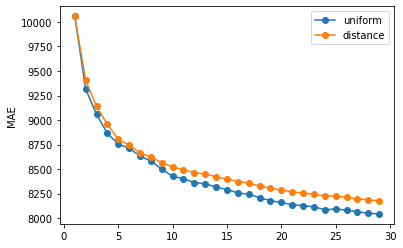

In [24]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

cv = KFold(n_splits = 10, shuffle = False) #
#  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html 


for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights, metric='euclidean')
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(X_train):
          # División train test aleatoria
          # train
          fx_train = X_train.iloc[train_fold]
          fy_train = y_train.iloc[train_fold]
          # test
          fx_test = X_train.iloc[test_fold]
          fy_test = y_train.iloc[test_fold]

          # entrenamiento y ejecución del modelo
          knn.fit( X = fx_train, y = fy_train)
          y_pred = knn.predict(X = fx_test)
          # evaluación del modelo
          mae = mean_absolute_error(fy_test, y_pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')      
    

plt.legend()
plt.show() 

### Prediction

In [30]:
# constructor
n_neighbors = 24
weights = 'uniform'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights)

# fit and predict
knn.fit( X = X_train, y = y_train)
y_pred = knn.predict(X = X_test)


from sklearn import metrics
print ("MAE:", metrics.mean_absolute_error(y_pred , y_test))
print ("MAPE:", metrics.mean_absolute_percentage_error(y_pred , y_test))
print ("MSE:", metrics.mean_squared_error(y_pred , y_test))
print ("R^2:", metrics.r2_score(y_pred , y_test))

MAE: 7599.978135257317
MAPE: 0.8913136643569914
MSE: 528483560.097882
R^2: -0.7200197092457445


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


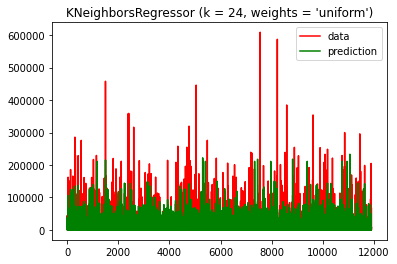

In [31]:
from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))

plt.show()

## 1.2 DecisionTrees

No handles with labels found to put in legend.


Min Value : 7909.922824915235 (4)


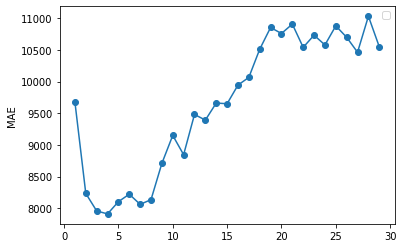

In [33]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn import tree

cv = KFold(n_splits = 10, shuffle = True)
total_scores = []
for i in range(1,30):
       fold_mae = []
       regr = tree.DecisionTreeRegressor(max_depth=i)
       for train_fold, test_fold in cv.split(X_train):
          # División train test aleatoria
          # train
          fx_train = X_train.iloc[train_fold]
          fy_train = y_train.iloc[train_fold]
          # test
          fx_test = X_train.iloc[test_fold]
          fy_test = y_train.iloc[test_fold]

          # entrenamiento y ejecución del modelo
          regr.fit(fx_train, fy_train)
          y_pred = regr.predict(fx_test)
          # evaluación del modelo
          mae = mean_absolute_error(fy_test, y_pred)
          fold_mae.append(mae)
       total_scores.append(sum(fold_mae)/len(fold_mae))
      
      
plt.plot(range(1,len(total_scores)+1), total_scores, 
           marker='o')
print ('Min Value : ' +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
plt.ylabel('MAE')      
plt.legend()
plt.show() 

In [34]:
from sklearn import tree
regr = tree.DecisionTreeRegressor(max_depth = 4)
regr.fit(X_train, y_train)
regr

DecisionTreeRegressor(max_depth=4)

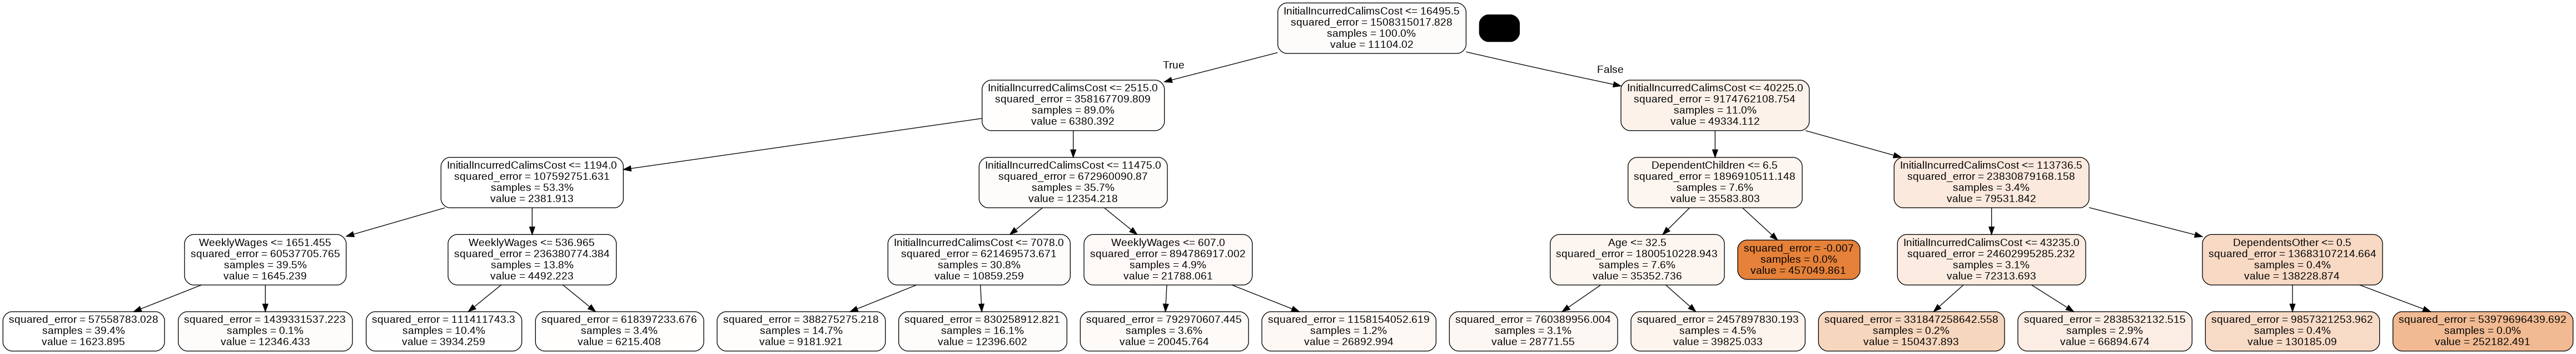

In [35]:
import pydot
from IPython.display import Image

from io import StringIO

dot_data = StringIO()

tree.export_graphviz(regr, out_file = dot_data, proportion = True,
                     feature_names=x_features, 
                     rounded = True, filled = True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

In [36]:
# FEATURE RELEVANCIES
print ('Feature Relevancies')
pd.DataFrame({'Attributes': x_features ,
              'Decision Tree': regr.feature_importances_})

Feature Relevancies


,Attributes,Decision Tree
0,Age,0.007525
1,DependentChildren,0.024911
2,DependentsOther,0.011691
3,WeeklyWages,0.002224
4,HoursWorkedPerWeek,0.000000
5,DaysWorkedPerWeek,0.000000
6,InitialIncurredCalimsCost,0.953649
7,Gender_F,0.000000
8,Gender_M,0.000000
9,Gender_U,0.000000


### Prediction

In [37]:
y_pred = regr.predict(X_test)

### Evaluation

In [38]:
from sklearn import metrics
print ("MAE:", metrics.mean_absolute_error(y_pred , y_test))
print ("MAPE:", metrics.mean_absolute_percentage_error(y_pred , y_test))
print ("MSE:", metrics.mean_squared_error(y_pred , y_test))
print ("R^2:", metrics.r2_score(y_pred , y_test))

MAE: 7593.617362644817
MAPE: 0.802198714253701
MSE: 526760248.0699377
R^2: -0.7397172182768719


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


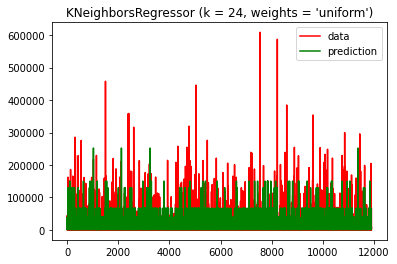

In [39]:
from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))

plt.show()

# LAMENTABLEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE

# 2. Optimized Model (RandomForests, Boosting + Hyperparameter Optimization)

# 3. Improvements (Include text data, other changes)